In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
import sys
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as pp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [3]:
path = os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'music-genre-classifier', 'data')
sys.path.append(path)

In [4]:
# Load LSTM features
npzfile = np.load(os.path.join(path, 'train.npz'), allow_pickle=True)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
npzfile = np.load(os.path.join(path, 'dev.npz'), allow_pickle=True)
X_dev = npzfile['arr_0']
y_dev = npzfile['arr_1']
npzfile = np.load(os.path.join(path, 'test.npz'), allow_pickle=True)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']

In [5]:
print('Train size: {}'.format(X_train.shape))
print('Dev size: {}'.format(X_dev.shape))
print('Test size: {}'.format(X_test.shape))
print('Train target: {}'.format(y_train.shape))
print('Dev target: {}'.format(y_dev.shape))
print('Test target: {}'.format(y_test.shape))

Train size: (8000, 130, 66)
Dev size: (1000, 130, 66)
Test size: (1000, 130, 66)
Train target: (8000,)
Dev target: (1000,)
Test target: (1000,)


In [6]:
scaler = []
X_train_sc = np.empty(X_train.shape)
X_dev_sc = np.empty(X_dev.shape)
X_test_sc = np.empty(X_test.shape)
for idx in range(X_train.shape[1]):
    scaler.append(StandardScaler().fit(np.squeeze(X_train[:, idx, :])))
    X_train_sc[:, idx, :] =  scaler[idx].transform(X_train[:, idx, :])
    X_dev_sc[:, idx, :] = scaler[idx].transform(X_dev[:, idx, :])
    X_test_sc[:, idx, :] = scaler[idx].transform(X_test[:, idx, :])

In [7]:
model_path = path = os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'music-genre-classifier')
# build network topology
model = keras.Sequential()
# add layer
model.add(keras.layers.LSTM(units=796, dropout=0.05, recurrent_dropout=0.35, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.LSTM(units=384,  dropout=0.05, recurrent_dropout=0.35, return_sequences=True))
model.add(keras.layers.LSTM(units=128,  dropout=0.05, recurrent_dropout=0.35, return_sequences=True))
model.add(keras.layers.LSTM(units=64,  dropout=0.05, recurrent_dropout=0.35, return_sequences=False))
model.add(keras.layers.Dense(units=10, activation="softmax"))
# learning rate scheduler
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10,
    decay_rate=0.75,
    staircase=True)
# callbacks
my_callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_path, 'saved_model', 'model.{epoch:03d}-{val_loss:.2f}.h5')),
    keras.callbacks.CSVLogger(os.path.join(model_path, 'history.csv'), separator=',', append=False)
]
# compile model
optimiser = keras.optimizers.Nadam(learning_rate=1e-5, clipnorm=1.0)
model.compile(
               optimizer=optimiser,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy']
              )
model.summary()

# train model
history = model.fit(X_train_sc, y_train, validation_data=(X_dev_sc, y_dev), batch_size=150, epochs=150, callbacks=my_callbacks)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 130, 796)          2747792   
_________________________________________________________________
lstm_1 (LSTM)                (None, 130, 384)          1814016   
_________________________________________________________________
lstm_2 (LSTM)                (None, 130, 128)          262656    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 10)                650       
Total params: 4,874,522
Trainable params: 4,874,522
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
54/54 [==============================] - 119s 2s/step - loss: 2.2522 - accuracy: 0.1770 - val_loss: 

In [8]:
print('Model Test Accuracy: {:.3f}'.format((model.predict_classes(X_test_sc) == y_test.reshape(-1)).sum() / X_test.shape[0]))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Model Test Accuracy: 0.923


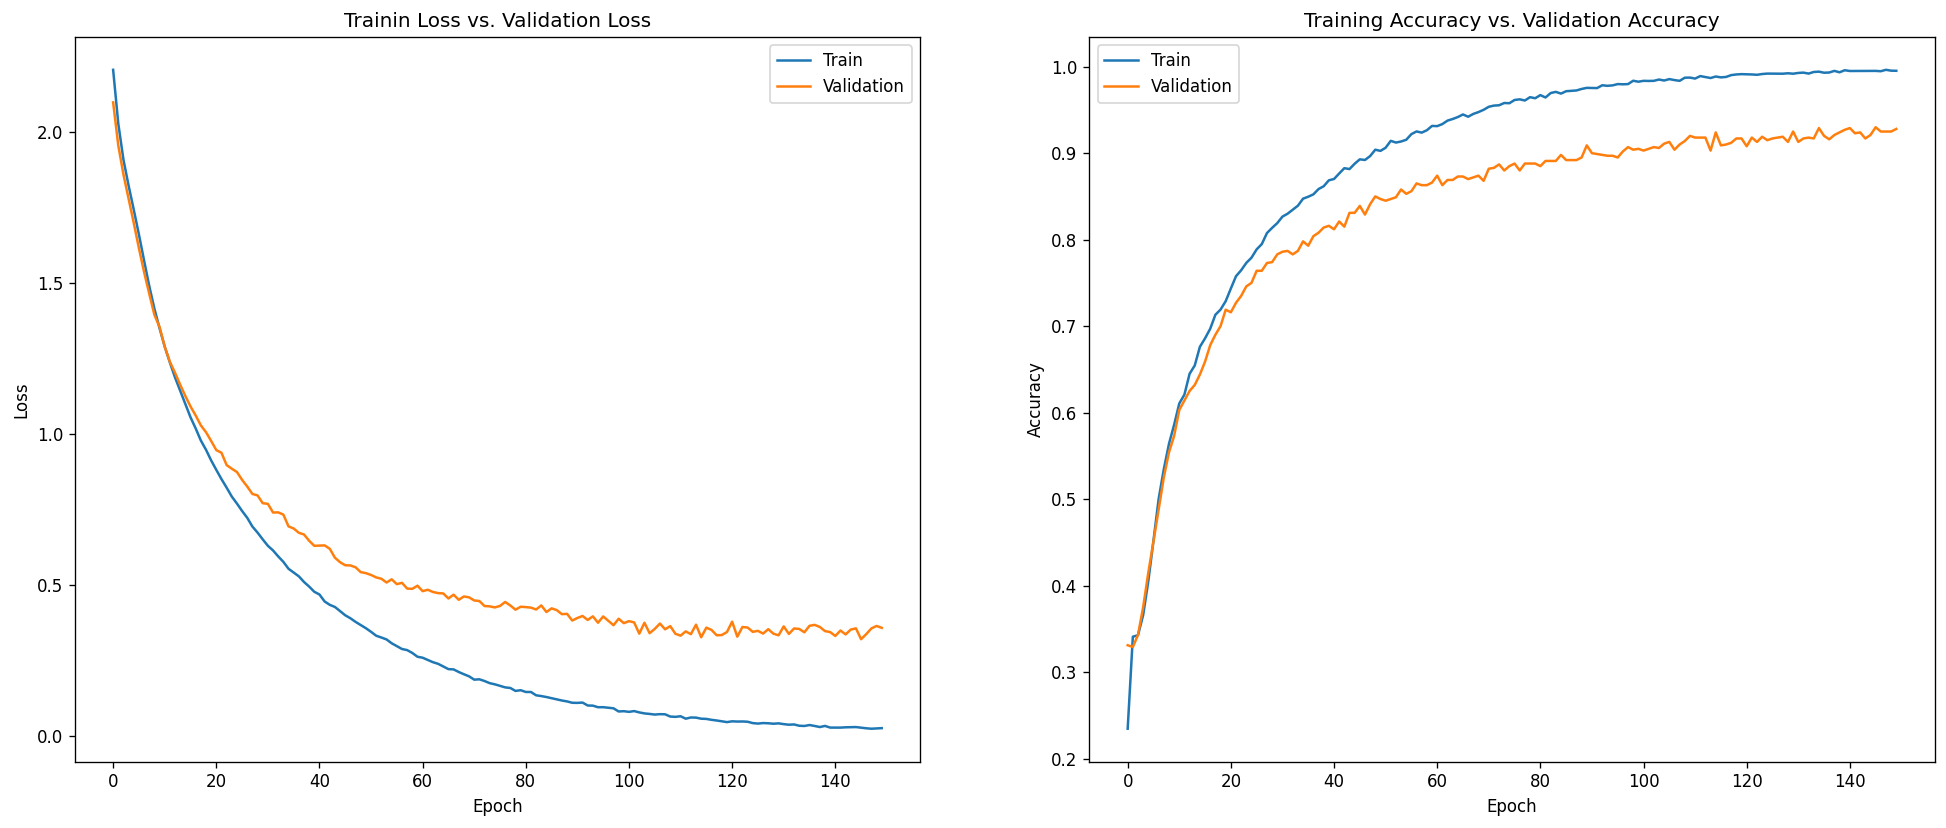

In [9]:
fig, axs = pp.subplots(1, 2, figsize=(20,8), dpi=120)
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[0].set_title('Trainin Loss vs. Validation Loss')
axs[1].set_title('Training Accuracy vs. Validation Accuracy')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper left')
axs[0].legend(['Train', 'Validation'], loc='upper right');

In [10]:
path = os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'music-genre-classifier', 'saved_model', 'new_model')
model.save(path)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/music-genre-classifier/saved_model/new_model/assets


In [11]:
path = os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'music-genre-classifier', 'history.csv')
hist = pd.DataFrame(history.history)
hist.to_csv(path, index=False)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


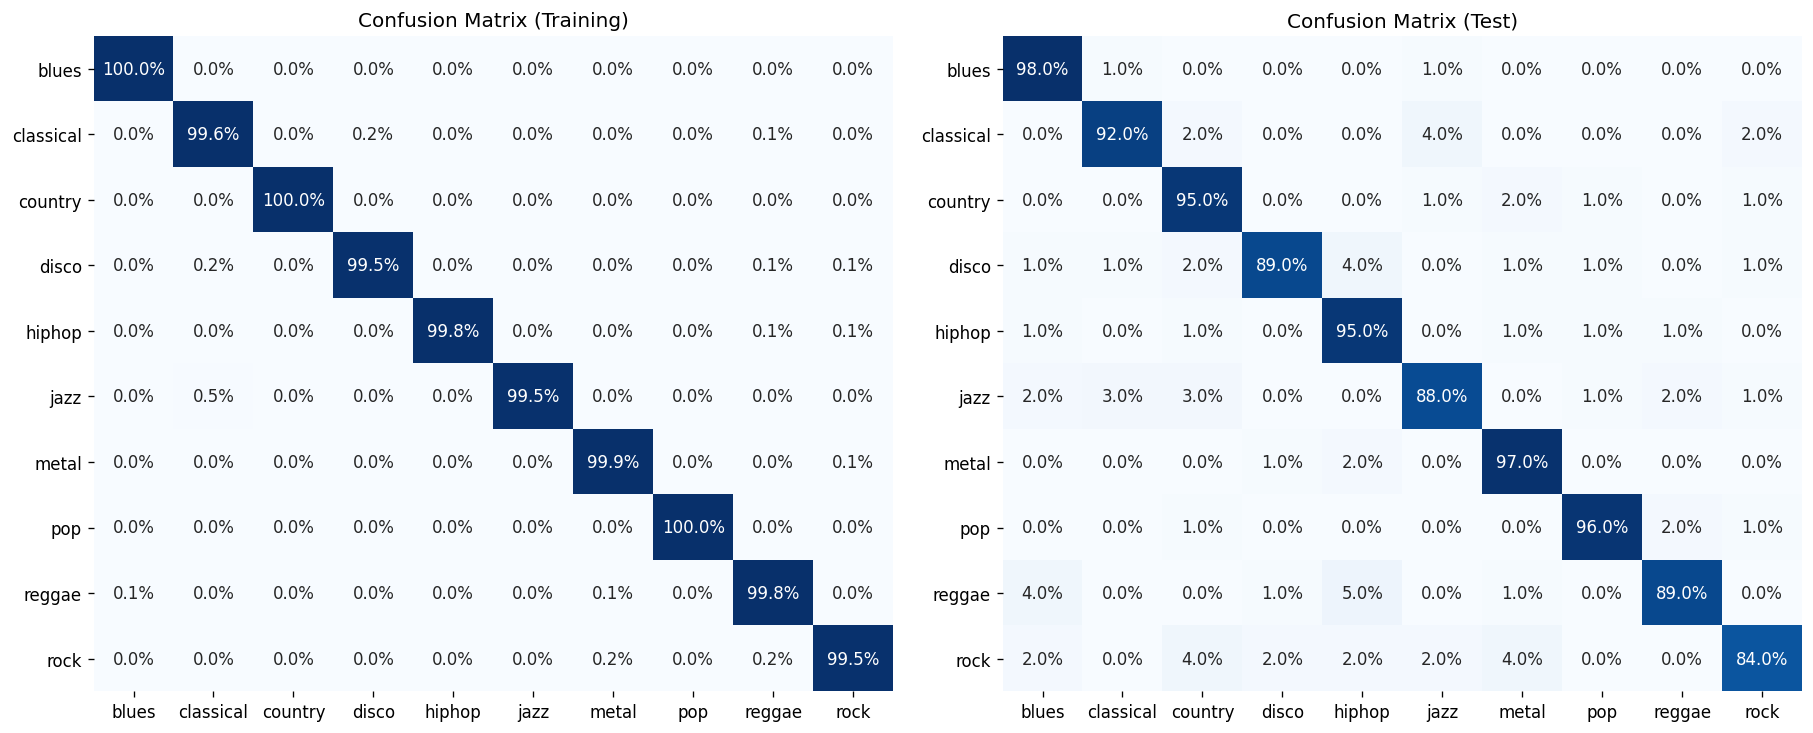

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
fig, axs = pp.subplots(1, 2, figsize=(15, 6), dpi=120, constrained_layout=True)
pp.rcParams.update({'font.size': 10})
cm = confusion_matrix(y_train, model.predict_classes(X_train_sc))
sns.heatmap(cm/(X_train.shape[0]/10) * 100, annot=True, fmt = '.1f', ax=axs[0], xticklabels=class_names, yticklabels=class_names, cmap='Blues', cbar=False)
cm = confusion_matrix(y_test, model.predict_classes(X_test_sc))
sns.heatmap(cm/(X_test.shape[0]/10) * 100, annot=True, fmt = '.1f', ax=axs[1], xticklabels=class_names, yticklabels=class_names, cmap='Blues', cbar=False)
for t in axs[0].texts: t.set_text(t.get_text() + "%")
for t in axs[1].texts: t.set_text(t.get_text() + "%")
axs[0].set_title('Confusion Matrix (Training)')
axs[1].set_title('Confusion Matrix (Test)')
axs[0].set_yticklabels(class_names, rotation=0)
axs[1].set_yticklabels(class_names, rotation=0);

In [22]:
path = os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'music-genre-classifier', 'saved_model', 'model.110-0.34.h5')
model_110 = keras.models.load_model(path)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


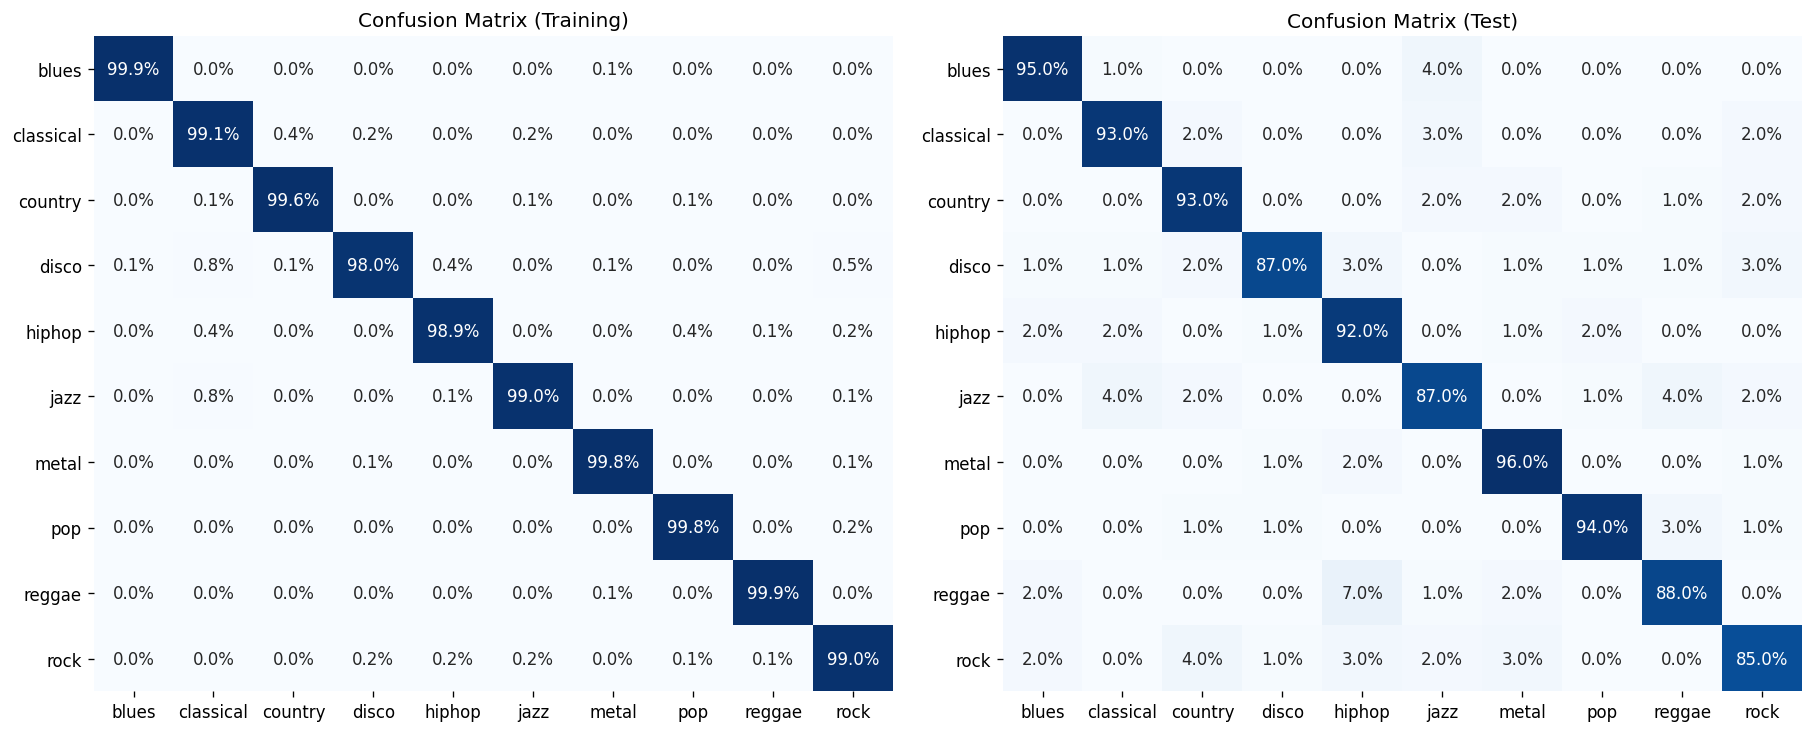

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
fig, axs = pp.subplots(1, 2, figsize=(15, 6), dpi=120, constrained_layout=True)
pp.rcParams.update({'font.size': 10})
cm = confusion_matrix(y_train, model_110.predict_classes(X_train_sc))
sns.heatmap(cm/(X_train.shape[0]/10) * 100, annot=True, fmt = '.1f', ax=axs[0], xticklabels=class_names, yticklabels=class_names, cmap='Blues', cbar=False)
cm = confusion_matrix(y_test, model_110.predict_classes(X_test_sc))
sns.heatmap(cm/(X_test.shape[0]/10) * 100, annot=True, fmt = '.1f', ax=axs[1], xticklabels=class_names, yticklabels=class_names, cmap='Blues', cbar=False)
for t in axs[0].texts: t.set_text(t.get_text() + "%")
for t in axs[1].texts: t.set_text(t.get_text() + "%")
axs[0].set_title('Confusion Matrix (Training)')
axs[1].set_title('Confusion Matrix (Test)')
axs[0].set_yticklabels(class_names, rotation=0)
axs[1].set_yticklabels(class_names, rotation=0);